In [1]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

E0000 00:00:1728742147.885785      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D1012 14:09:07.894684632      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1012 14:09:07.894699736      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1012 14:09:07.894703084      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1012 14:09:07.894705391      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1012 14:09:07.894707879      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

In [2]:
# Load the dataset
data = np.load('/kaggle/input/1024age5/AGE_1024_512_Class5.npz') #/home/showv/BanglaOCR/Dataset
X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']

# Reshape the images (from flat to original size)
X_train = X_train.reshape((-1, 512, 1024, 1)) #.astype(np.float16)  # Grayscale
X_test = X_test.reshape((-1, 512, 1024, 1)) #.astype(np.float16)
    
# Convert grayscale to 3 channels by repeating the single channel
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# Normalize pixel values (0-255) to range (0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (9154, 512, 1024, 3)
y_train shape: (9154, 5)
X_test shape: (2289, 512, 1024, 3)
y_test shape: (2289, 5)


In [3]:
# # !echo $CUDA_VISIBLE_DEVICES
# # !export CUDA_VISIBLE_DEVICES=0,1

# import tensorflow as tf

# # Check if GPU is available
# print(tf.config.list_physical_devices('GPU'))
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [4]:
import tensorflow as tf

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# instantiate a distribution strategy
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

# Create a strategy for distributed training
#strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1728742279.105914      13 service.cc:145] XLA service 0x58b156780f90 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728742279.105969      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1728742279.105974      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1728742279.105976      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1728742279.105979      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1728742279.105981      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1728742279.105984      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1728742279.105986      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1728742279.105989      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [5]:
#with strategy.scope():
with tpu_strategy.scope():
    # Define the base model with ImageNet weights, without the top layers
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(512, 1024, 3))

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers on top of the base model
    inputs = Input(shape=(512, 1024, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)  # Global average pooling layer
    x = Dense(128, activation='relu')(x)  # Custom dense layer
    outputs = Dense(5, activation='softmax')(x)  # Output layer for 2 classes

    # Create the final model
    model = Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
model.summary()

I0000 00:00:1728742284.558074      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 1024, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 14, 30, 2048)   │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,065,701 (84.17 MB)

 Trainable params: 262,917 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [6]:
class SaveHistory(Callback):
    def __init__(self, filename):
        super(SaveHistory, self).__init__()
        self.filename = filename

    def on_epoch_end(self, epoch, logs=None):
        # If the file exists, load the previous history
        try:
            with open(self.filename, 'r') as f:
                history = json.load(f)
        except FileNotFoundError:
            history = {}
        
        # Append new logs to the history
        for key, value in logs.items():
            if key not in history:
                history[key] = []
            history[key].append(value)
        
        # Save the updated history to file
        with open(self.filename, 'w') as f:
            json.dump(history, f)


# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#checkpoint = ModelCheckpoint('AP-InceptionV3_1024Age_checkpoint.keras', monitor='val_loss', save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
history_callback = SaveHistory('AP-InceptionV3_1024Age_history.json')

In [7]:
# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,  # You can increase epochs based on performance
                    batch_size=64,
                    callbacks=[early_stopping, history_callback])

Epoch 1/100


2024-10-12 14:14:30.466938: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1728742472.601534     834 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(5210a19f809af25d:0:0), session_name()


  1/144 ━━━━━━━━━━━━━━━━━━━━ 1:09:24 29s/step - accuracy: 0.1250 - loss: 1.6804

I0000 00:00:1728742494.662858     834 tpu_compile_op_common.cc:245] Compilation of 5210a19f809af25d:0:0 with session name  took 22.061206755s and succeeded
I0000 00:00:1728742494.686987     834 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(5210a19f809af25d:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_9512651999708368105", property.function_library_fingerprint = 24926323051830578, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "8,512,1024,3,;8,5,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728742494.687038     834 tpu_compilation_cache_interface.cc:541] After adding entry for key 52

143/144 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.2802 - loss: 1.5736

I0000 00:00:1728742557.747565     765 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(fb4e2bdf506b1988:0:0), session_name()


144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.2804 - loss: 1.5734

I0000 00:00:1728742576.794485     765 tpu_compile_op_common.cc:245] Compilation of fb4e2bdf506b1988:0:0 with session name  took 19.046880344s and succeeded
I0000 00:00:1728742576.814316     765 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(fb4e2bdf506b1988:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_9512651999708368105", property.function_library_fingerprint = 24926323051830578, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,512,1024,3,;2,5,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728742576.814359     765 tpu_compilation_cache_interface.cc:541] After adding entry for key fb

144/144 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.2806 - loss: 1.5732 - val_accuracy: 0.3449 - val_loss: 1.4936
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 89s 606ms/step - accuracy: 0.3494 - loss: 1.4828 - val_accuracy: 0.3868 - val_loss: 1.4300
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 89s 609ms/step - accuracy: 0.3850 - loss: 1.4256 - val_accuracy: 0.4007 - val_loss: 1.4056
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 89s 606ms/step - accuracy: 0.4312 - loss: 1.3691 - val_accuracy: 0.4146 - val_loss: 1.3591
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 88s 595ms/step - accuracy: 0.4426 - loss: 1.3215 - val_accuracy: 0.4321 - val_loss: 1.3343
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 88s 595ms/step - accuracy: 0.4663 - loss: 1.2953 - val_accuracy: 0.4321 - val_loss: 1.3398
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 90s 611ms/step - accuracy: 0.4774 - loss: 1.2919 - val_accuracy: 0.4739 - val_loss: 1.3032
Epoch 8/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 90s 610ms/step - accuracy: 0.4873 - loss: 1.2523 

In [8]:
# Load the saved model and history
# from tensorflow.keras.models import load_model

# model = load_model('AP-InceptionV3_1024Age_checkpoint.keras')
# with open('AP-InceptionV3_1024Age_history.json', 'r') as f:
#     history = json.load(f)

# history = model.fit(X_train, y_train,
#                     validation_data=(X_test, y_test),
#                     epochs=10,  # You can increase epochs based on performance
#                     batch_size=32,
#                     callbacks=[early_stopping, checkpoint, history_callback])

In [9]:
# Save the model in .keras format
model.save('AP-InceptionV3_Model_1024Age_Trained.keras')

ValueError: Device /job:localhost/replica:0/task:0/device:CPU:0 is not found

In [14]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.5009 - loss: 1.1445
Test accuracy: 52.61%


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow.keras.optimizers as optimizers
import matplotlib.pyplot as plt

# Get the default learning rate for the Adam optimizer
d_learning_rate = optimizers.Adam().get_config()['learning_rate']

# Predictions
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics calculation
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Additional information
print("Number of Epochs:", len(history.history['accuracy']))
print("Size of Image:", X_train.shape[1:])
print("Learning Rate: ",d_learning_rate)

2024-10-12 16:49:57.966961: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/dense_1/Add/ReadVariableOp.
I0000 00:00:1728751798.458412     744 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(804491749945222a:0:0), session_name()


 1/72 ━━━━━━━━━━━━━━━━━━━━ 26:22 22s/step

I0000 00:00:1728751816.375764     744 tpu_compile_op_common.cc:245] Compilation of 804491749945222a:0:0 with session name  took 17.917292147s and succeeded
I0000 00:00:1728751816.393656     744 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(804491749945222a:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_1639345117001957113", property.function_library_fingerprint = 7419565317643936467, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728751816.393693     744 tpu_compilation_cache_interface.cc:541] After adding entry for key 80449174994

71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step

I0000 00:00:1728751843.907804     796 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(c53284944dc2c62b:0:0), session_name()


72/72 ━━━━━━━━━━━━━━━━━━━━ 63s 578ms/step


I0000 00:00:1728751857.384133     796 tpu_compile_op_common.cc:245] Compilation of c53284944dc2c62b:0:0 with session name  took 13.476283s and succeeded
I0000 00:00:1728751857.403750     796 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(c53284944dc2c62b:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_15687652280582327261", property.function_library_fingerprint = 6564147107310324209, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,512,1024,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728751857.403787     796 tpu_compilation_cache_interface.cc:541] After adding entry for key

Accuracy: 0.5762341633901267
Precision: 0.5863079656509675
Recall: 0.5779438899123622
F1 Score: 0.5785349675073651
Number of Epochs: 100
Size of Image: (512, 1024, 3)
Learning Rate:  0.0010000000474974513


72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 350ms/step


<Figure size 1600x1600 with 0 Axes>

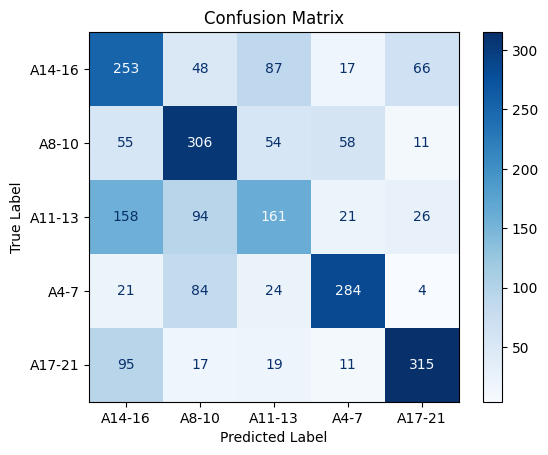

In [12]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the model and get predictions
y_pred = model.predict(X_test)

# Convert the predictions from one-hot encoded to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
labels = ['A14-16', 'A8-10', 'A11-13', 'A4-7', 'A17-21']  # Adjust according to your labels

plt.figure(figsize=(16, 16))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Add title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

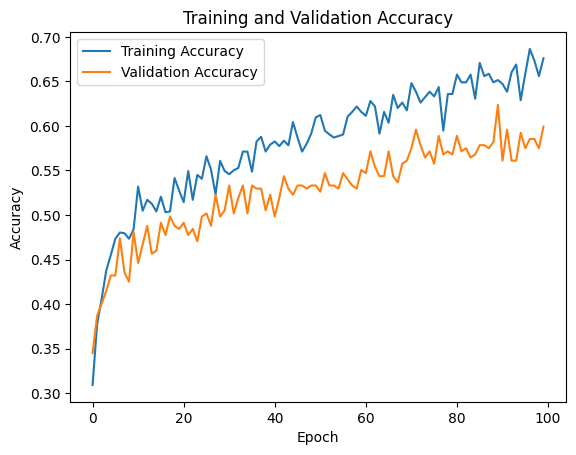

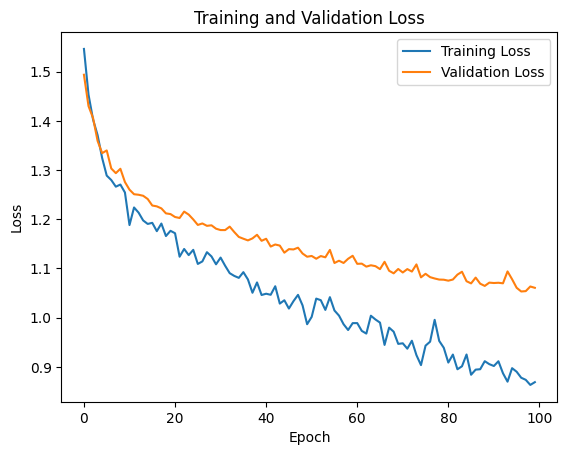

In [13]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()